In [1]:
import numpy as np
from tkinter import *
import matplotlib.pyplot as plt
from scipy.interpolate import spline
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib.ticker import MultipleLocator

import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy import integrate
from scipy import ndimage
from astropy.modeling import models, fitting


global CONFIG
global PLT
global ROI
global INIT
global LIM
global BFIT
global pcov
global TRGBcolor
global bestiLF
global bestrLF
global magtics_smooth
%matplotlib inline

CONFIG = { 'parr' : None,
    'farr' : None }

PLT = { 'cl' : 1,
    'ch' : 2.3,
    'ml' : 23,
    'mh' : 25 }



RANGE = { 'l' : -1.,
          'h' : 1. }

# THIS IS USED FOR LABELS ON PLOTS
band1='F606W'
band2='F814W'

# THIS IS USED FOR the actual computations
# the diagram is defined as
# magI vs. magV - magI


INIT= { 'TRGB' : 99,
       'a' : 0.3,
       'b' : 0.3,
       'c' : 0.3 }

LIM = { 'TRGBl' : -99,
    'TRGBh' : 99,
    'al' : -99,
    'ah' : 99,
    'bl' : -99,
    'bh' : 99,
    'cl' : -99,
    'ch' : 99 }

###### Reading of photometry data, assuming that V and I magnitudes are in columns 1 and 3

In [2]:
# If using a spacially selected diagram, then this is the way to read it.
#pname = "And18.photometry"
#pname = "ALFAZOAJ1952+1428.photometry"
#arr = np.genfromtxt(pname,usecols=(0,1,2,3))

# if using a regular .phot file, then this is the way to read it
pname = "CENA-132302.phot2"
arr = np.genfromtxt(pname,usecols=(16,17,29,30))


inputV = arr[:,0]
inputerr_V = arr[:,1]
inputI = arr[:,2]
inputerr_I = arr[:,3]


In [3]:
inputerr_V[0]

0.002

###### Reading fake photometry results, assuming the order is Vinput Iinput Voutput Ioutput Verr Ierr

In [4]:
fname = "CENA-132302.phot.fake2"
arr = np.genfromtxt(fname)

stV = arr[:,0]
stI = arr[:,1]
fakeV   = arr[:,2]
fakeI   = arr[:,3]
fakeVerr   = arr[:,4]
fakeIerr   = arr[:,5]

# create a vector without the magnitudes not retrieved
fakeV[np.where(fakeV>98)]=np.nan
fakeI[np.where(fakeI>98)]=np.nan

stV_sel = stV[np.logical_and(fakeVerr<0.3,fakeV<98)]
fakeV_sel   = fakeV[np.logical_and(fakeVerr<0.3,fakeV<98)]
stI_sel = stI[np.logical_and(fakeVerr<0.3,fakeI<98)]
fakeI_sel   = fakeI[np.logical_and(fakeVerr<0.3,fakeI<98)]

In [5]:
def GetSmoothedStats(Xall,X,Y):
    medx = np.median(X)
    w=np.median([abs(x-medx) for x in X])/0.6745
    w=w*(4/(3*len(X)))**(1/5)
    w=max(w/4,0.005)
    xi = np.linspace(min(X),max(X),100)
    xi=np.append(xi,np.max(xi)+0.5*w)
    xi=np.append(xi,np.max(xi)+w)

    dX=Y-X
    nall = np.zeros(len(xi))
    n = nall.copy()
    b = nall.copy()
    s = nall.copy()
    for k in range(len(xi)):
        nall[k]=np.sum(np.e**(-0.5*((xi[k]-Xall)/w)**2))/(w*np.sqrt(2*np.pi))
        p = np.e**(-0.5*((xi[k]-X)/w)**2) / (w*np.sqrt(2*np.pi))
        n[k]   =np.sum(np.e**(-0.5*((xi[k]-X   )/w)**2))/(w*np.sqrt(2*np.pi))
        b[k]=np.sum(dX*p) / n[k]
        s[k]=np.sqrt(np.sum(dX**2*p)/n[k]-b[k]**2)
        if n[k]>=2:
            s[k]=s[k]*np.sqrt(n[k]/(n[k]-1))
    
    c=n.copy()/nall.copy()
    ind = np.logical_and(np.isfinite(c),np.isfinite(b),np.isfinite(s))
    c=c[ind]
    b=b[ind]
    s=s[ind]
    xi=xi[ind]
    return xi,c,b,s

###### Calculate the 4th order coefficient that approximate the error, completeness and bias functions

In [6]:
mag_V,complet_V,bias_V,errors_V = GetSmoothedStats(stV,stV_sel,fakeV_sel)
mag_I,complet_I,bias_I,errors_I = GetSmoothedStats(stI,stI_sel,fakeI_sel)
deg=4
centerCoef = np.polyfit(mag_I, bias_I, deg=deg)
errCoef = np.polyfit(mag_I, errors_I, deg=deg)
compltCoef = np.polyfit(mag_I,complet_I, deg=deg)


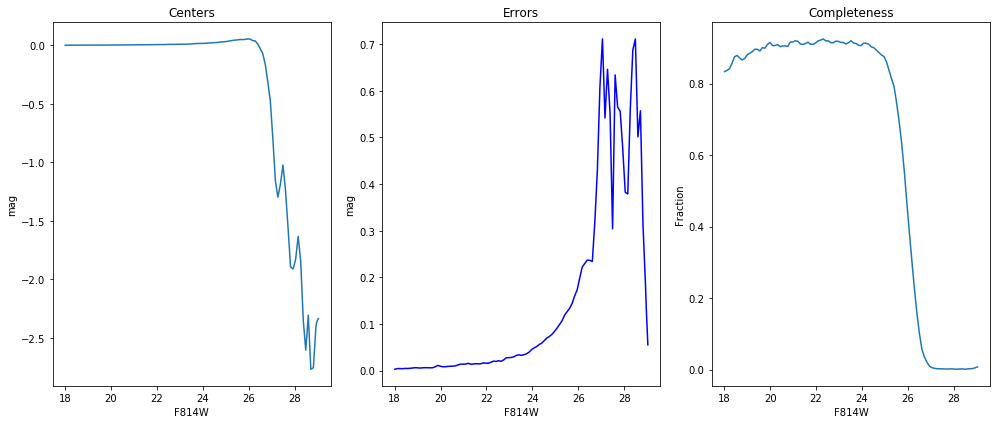

In [7]:
fig = plt.figure(figsize=(14,6))
PLTCenters = fig.add_subplot(131)
PLTCenters.plot(mag_I,bias_I)
PLTCenters.set_xlabel(band2)
PLTCenters.set_ylabel("mag")
PLTCenters.set_title("Centers")
        
PLTErrors= fig.add_subplot(132)
PLTErrors.plot(mag_I,errors_I,color='blue')
PLTErrors.set_xlabel(band2)
PLTErrors.set_ylabel("mag")
PLTErrors.set_title("Errors")

Completeness = fig.add_subplot(133)
Completeness.plot(mag_I,complet_I)
Completeness.set_xlabel(band2)
Completeness.set_ylabel("Fraction")
Completeness.set_title("Completeness")
fig.tight_layout()
plt.show()

### Color magnitude diagram with region used for fitting

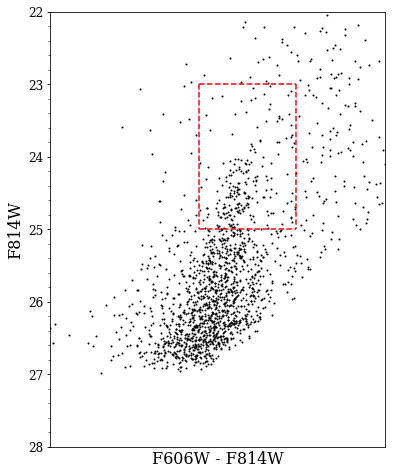

In [8]:

plt.rc('font',family='serif')
plt.rc('xtick',labelsize='12')
plt.rc('ytick',labelsize='12')
cmd = plt.figure(figsize=(6,8))
ax = cmd.add_subplot(1,1,1)


ax.plot(inputV-inputI, inputI,'o',markersize=1, color='black')
ax.plot( [ PLT['cl'], PLT['cl']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['ch'], PLT['ch']], [PLT['ml'], PLT['mh'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['ml'], PLT['ml'] ] , '--', color='red')
ax.plot( [ PLT['cl'], PLT['ch']], [PLT['mh'], PLT['mh'] ] , '--', color='red')
ax.set_xlabel("%s - %s" %(band1,band2), fontsize=16)
ax.set_ylabel(band2, fontsize=16)
ax.set_xlim((-1,3.5))
ax.set_ylim((28,22))
#cmd.tight_layout()
majorLocator = MultipleLocator(1)
minorLocator = MultipleLocator(0.2)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator) 
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_minor_locator(minorLocator) 
#plt.savefig('cmd.ps', dpi=300)


###### Calculation of the luminosity function

In [9]:
        binsize = 0.1
        bin = np.arange( PLT['ml']-0.5, PLT['mh']+0.5, binsize)
        magtics = bin[1:] - binsize/2.
        LF, binedeges = np.histogram([i for v,i in zip(inputV,inputI) if (v-i>=PLT['cl'] and v-i<=PLT['ch'] and i>=PLT['ml'] and i<=PLT['mh'])],bins=bin)

###### Calculation of smoothed luminosity function following Sakai et al. 1996

In [10]:
#m = np.linspace(np.amin(F814W),np.amax(F814W),100)
m = np.linspace(PLT['ml']-0.5,PLT['mh']+0.5,50)
#m = np.arange( PLT['ml']-0.5, PLT['mh']+0.5, binsize)
dm = m[1]-m[0]
smoothLF=np.zeros(len(m))
#print (dm*len(m))
for k in range(len(smoothLF)):
    smoothLF[k]=np.sum([(1/(np.sqrt(2*np.pi)*sigma)*np.e**(-1.0*((mag-m[k])**2/(2*sigma**2)))) for mag,sigma in zip(inputI,inputerr_I)])
# smooth

# calculate integral under the curve
normalization = np.sum(smoothLF)*dm
smoothLF = smoothLF/normalization
#smoothLF = np.convolve(smoothLF,[1,1,1],'same')

total = np.sum(smoothLF)
print(total)

# reduce normalization
normalization = normalization / (dm*len(m))
# SOBEL FILTERING
LF_sobel = ndimage.sobel(smoothLF)

16.3333333333


In [11]:
inputerr_I

array([ 0.001,  0.002,  0.002, ...,  0.219,  0.213,  0.208])

###### Plot of luminosity function and first derivative (sobel), both linear and logarithmic

/Users/Deep/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/Users/Deep/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  import sys


(0, 0.98632513900557428)

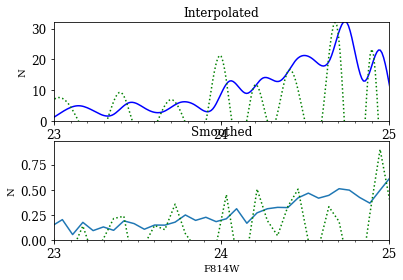

In [12]:
        fig=plt.figure()
        LF_prime = np.diff(LF) / binsize
        magtics_prime = bin[1:-1]
        # smoothed version built by interpolating (spline)
        magtics_interp = np.arange(min(bin),max(bin), 0.01)
        LF_interp = spline(magtics, LF, magtics_interp)
        LF_prime_interp = spline(magtics_prime, LF_prime, magtics_interp)

        majorLocator = MultipleLocator(1)
        minorLocator = MultipleLocator(0.1)
        LFplt = fig.add_subplot(211)
        LFplt.plot(magtics_interp,LF_interp,color='blue')
        LFplt.set_title("Interpolated")
        ymaxLF = np.amax(LF)
        ymaxLFprime = np.amax(LF_prime_interp)
        # rescale LFPRIME
        LF_prime_interp = LF_prime_interp / ymaxLFprime * ymaxLF
        LFplt.plot(magtics_interp,LF_prime_interp,':',color='green')

        LFprimemax = np.amax(LF_prime_interp)
        LFplt.xaxis.set_major_locator(majorLocator)
        LFplt.xaxis.set_minor_locator(minorLocator) 
        LFplt.set_xlim((PLT['ml'],PLT['mh']))
        LFplt.set_xlabel(band2)
        LFplt.set_ylabel("N")
        ymin,ymax = LFplt.get_ylim()
        ymax = np.amax(LF)
        LFplt.set_ylim((0,ymax))

        LFsmoothplt = fig.add_subplot(212)
        LFsmoothplt.plot(m,smoothLF)
        # rescale sobel filter
        ymaxLF = np.amax(smoothLF)
        ymaxsobel = np.amax(LF_sobel)
        LF_sobel = LF_sobel/ymaxsobel*ymaxLF
        LFsmoothplt.plot(m,LF_sobel,':',color='green')
        LFsmoothplt.set_title("Smoothed")
        LFsmoothplt.xaxis.set_major_locator(majorLocator)
        LFsmoothplt.xaxis.set_minor_locator(minorLocator)
        LFsmoothplt.set_xlabel(band2)
        LFsmoothplt.set_ylabel("N")
        ymin,ymax = LFsmoothplt.get_ylim()
        LFsmoothplt.set_xlim((PLT['ml'],PLT['mh']))
        LFsmoothplt.set_ylim((0,ymax))
        
        
        

In [13]:
pmagmax = np.amax(inputI) #max(x[1] for x in parr)
pmagmin = np.amin(inputI) #min(x[1] for x in parr)
fmagmax = np.amax(stV) #max(x[1] for x in farr)
fmagmin = np.amin(stI) #min(x[1] for x in farr)
deg = 4
np.random.seed(0)

### Definition of errors, bias, compleness, model LF, and real LF (with obs. effects applied)

In [14]:
def idealLF(m,a,b,c,mTRGB):
        if m >= mTRGB:
            return 10**(a*(m-mTRGB)+b)
        else :
            return 10**(c*(m-mTRGB))

def Compltfunc(m):
        return compltCoef[0]*m**4 + compltCoef[1]*m**3 + compltCoef[2]*m**2 + compltCoef[3]*m**1 + compltCoef[4]
        #return 1.0

def mbias(m):
        return centerCoef[0]*m**4 + centerCoef[1]*m**3 + centerCoef[2]*m**2 + centerCoef[3]*m**1 + centerCoef[4]+m
        #return 0.001
def merr(m):
        return errCoef[0]*m**4 + errCoef[1]*m**3 + errCoef[2]*m**2 + errCoef[3]*m**1 + errCoef[4]    
        #return 0.01
def ErrFunc(m, m_prime):
        return (1 / (np.sqrt(2*np.pi)* merr(m_prime) )) * np.e**( - ( m - mbias(m_prime) )**2 / ( 2 * merr(m_prime)**2) )    

def limitFunc(a,b,c,mTRGB):
        " If parameter(s) is out of allowed range, return a big number and add it to LF, preventing fitting procedure choose parameters user doesn't want"
        if a<LIM['al'] or a>LIM['ah'] or b<LIM['bl'] or b>LIM['bh'] or c<LIM['cl'] or c>LIM['ch'] or mTRGB<LIM['mTRGBl'] or mTRGB>LIM['mTRGBh']: return 1.e100
        else: return 0    
    
def realLF(mlist, a, b, c, mTRGB):  
        binsize = mlist[1]-mlist[0]
        print(a,b,c, mTRGB)
        rLF=[]
        for m in mlist:
            rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*Compltfunc(m_prime)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
            #rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
        return np.asarray(rLF)/(sum(rLF)*binsize) + limitFunc(a,b,c,mTRGB)


## Initial fit guess

In [15]:
INIT['TRGB']=23.9
LIM['mTRGBl']=22
LIM['mTRGBh']=25

INIT['a']=0.25
LIM['al']=0
LIM['ah']=5

INIT['b']=0.25
LIM['bl']=0
LIM['bh']=5

INIT['c']=0.25
LIM['cl']=0
LIM['ch']=5


In [16]:
        magnitudes_I=[]
        magnitudes_VI=[]
        for x in zip(inputV,inputI):
            if ( x[0]-x[1] >= PLT['cl'] and x[0]-x[1] <= PLT['ch'] ):
                magnitudes_I.append(x[1])
                magnitudes_VI.append([x[0],x[1]])
        binsize=0.1
        bins = np.arange(INIT['TRGB']+RANGE['l'], INIT['TRGB']+RANGE['h'], binsize)
        obsLF, bin_edges = np.histogram(magnitudes_I, bins=bins, density=True)
        somma = np.sum(obsLF)
        print(somma)
        bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
        smoothed_bins = np.arange(min(bin_edges),max(bin_edges)-binsize/2,0.02)
        smoothed_obsLF = spline(bin_centers,obsLF,smoothed_bins)
        
        

10.0


/Users/Deep/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


1.72972972973


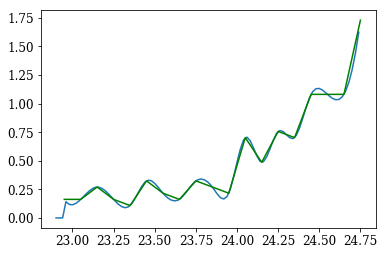

In [17]:
plt.plot(smoothed_bins,smoothed_obsLF)
plt.plot(bin_centers,obsLF,color='green')
print(np.amax(obsLF))

In [18]:

varini=[ INIT['a'], INIT['b'], INIT['c'], INIT['TRGB'] ]

global BFIT
global pcov
global TRGBcolor
TRGBcolor = [0., 0., 0.,]


#BFIT, pcov = curve_fit(realLF, m, smoothLF, p0=varini)
#curve_fit(realLF,m, smoothLF, p0=varini,full_output=True)
BFIT, pcov, info, mesg, ierr = curve_fit(realLF, m, smoothLF, p0=varini,full_output=True)
print("Best fit")
print("TRGB: ",BFIT[3])
print("a: ",BFIT[0])
print("b: ",BFIT[1])
print("c: ",BFIT[2])


0.25 0.25 0.25 23.9
0.25 0.25 0.25 23.9
0.25 0.25 0.25 23.9
0.250000003725 0.25 0.25 23.9
0.25 0.250000003725 0.25 23.9
0.25 0.25 0.250000003725 23.9
0.25 0.25 0.25 23.9000003561
0.335285813521 0.165470984704 1.02368031587 23.8983272729
0.335285818517 0.165470984704 1.02368031587 23.8983272729
0.335285813521 0.16547098717 1.02368031587 23.8983272729
0.335285813521 0.165470984704 1.02368033113 23.8983272729
0.335285813521 0.165470984704 1.02368031587 23.898327629
0.336110827844 0.101126906113 2.67186188038 23.8811392446
0.336110832853 0.101126906113 2.67186188038 23.8811392446
0.336110827844 0.10112690762 2.67186188038 23.8811392446
0.336110827844 0.101126906113 2.6718619202 23.8811392446
0.336110827844 0.101126906113 2.67186188038 23.8811396005
0.3263815561 -0.76371208598 4.12668931738 24.0311893152
0.32616727917 -0.0472320291979 2.71505378416 23.8564399282
0.333338299417 0.0959780045183 2.67198566243 23.8694761901
0.333338304384 0.0959780045183 2.67198566243 23.8694761901
0.3333382994

0.329491860352 1.51827979127 4.06887196485 23.7170998333
0.329491860352 1.51827979127 4.06887190422 23.7171001867
0.329492564372 1.52226302566 4.07075494045 23.7170525393
0.329492569282 1.52226302566 4.07075494045 23.7170525393
0.329492564372 1.52226304834 4.07075494045 23.7170525393
0.329492564372 1.52226302566 4.07075500111 23.7170525393
0.329492564372 1.52226302566 4.07075494045 23.7170528927
0.329493078991 1.5250509031 4.07207266636 23.7234052345
0.329492430771 1.52263366865 4.07093012873 23.717897118
0.32949243006 1.5224412441 4.07083917723 23.7174586431
0.32949243497 1.5224412441 4.07083917723 23.7174586431
0.32949243006 1.52244126679 4.07083917723 23.7174586431
0.32949243006 1.5224412441 4.07083923789 23.7174586431
0.32949243006 1.5224412441 4.07083917723 23.7174589965
0.329489180748 1.52267592686 4.07095022059 23.7173787757
0.329489185658 1.52267592686 4.07095022059 23.7173787757
0.329489180748 1.52267594955 4.07095022059 23.7173787757
0.329489180748 1.52267592686 4.07095028125

In [19]:
perr=np.sqrt(np.diag(pcov))


In [20]:
perr

array([  3.32209350e-02,   5.61899878e+06,   2.81101740e+03,
         1.49216412e+06])

0.25 0.25 0.25 23.9
0.329491839998 1.57364137619 4.09501656454 23.7170525607


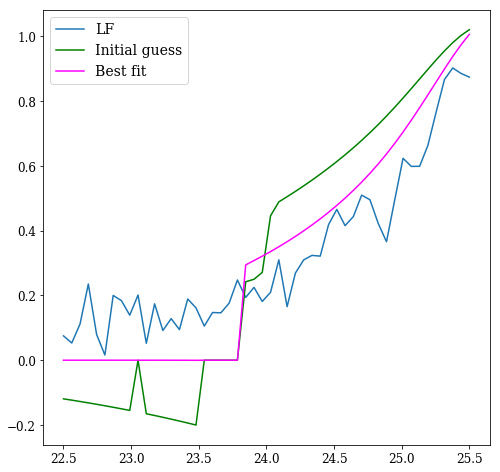

In [21]:
initial_guess = realLF(m,INIT['a'],INIT['b'],INIT['c'],INIT['TRGB'])
#calculated_function = [idealLF(x,BFIT[0],BFIT[1],BFIT[2],BFIT[3]) for x in bin_centers]
# use this for astropy
#calculated_function = astropy_realLF.evaluate(m,a=BFIT[0],b=BFIT[1],c=BFIT[2],mTRGB=BFIT[3])
# use this for scipy.curve_fit
calculated_function = realLF(m,a=BFIT[0],b=BFIT[1],c=BFIT[2],mTRGB=BFIT[3])
#plt.plot(bin_centers,obsLF)
#plt.plot(bin_centers,initial_guess,color="green")
#plt.plot(bin_centers,calculated_function,color='magenta')
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
ax.plot(m,smoothLF, label='LF')
ax.plot(m,initial_guess,color="green", label='Initial guess')
ax.plot(m,calculated_function,color='magenta', label='Best fit')
legend = ax.legend(loc='upper left', fontsize=14)

In [22]:
m

array([ 22.5       ,  22.56122449,  22.62244898,  22.68367347,
        22.74489796,  22.80612245,  22.86734694,  22.92857143,
        22.98979592,  23.05102041,  23.1122449 ,  23.17346939,
        23.23469388,  23.29591837,  23.35714286,  23.41836735,
        23.47959184,  23.54081633,  23.60204082,  23.66326531,
        23.7244898 ,  23.78571429,  23.84693878,  23.90816327,
        23.96938776,  24.03061224,  24.09183673,  24.15306122,
        24.21428571,  24.2755102 ,  24.33673469,  24.39795918,
        24.45918367,  24.52040816,  24.58163265,  24.64285714,
        24.70408163,  24.76530612,  24.82653061,  24.8877551 ,
        24.94897959,  25.01020408,  25.07142857,  25.13265306,
        25.19387755,  25.25510204,  25.31632653,  25.37755102,
        25.43877551,  25.5       ])

In [23]:
def bestidealLF( mlist, a, b, c, mTRGB):
        iLF=[]
        for m in mlist:
            if m >= mTRGB: iLF.append( 10**(a*(m-mTRGB)+b ))
            else: iLF.append( 10**(c*(m-mTRGB)) )
        return np.asarray(iLF)
 
def bestrealLF( mlist, a, b, c, mTRGB):
        rLF=[]
        for m in mlist:
            rLF.append(integrate.quad(lambda m_prime: idealLF(m_prime,a,b,c,mTRGB)*Compltfunc(m_prime)*ErrFunc(m,m_prime),pmagmin, pmagmax)[0])
        return np.asarray(rLF)
    
bestiLF = bestidealLF(m,BFIT[0],BFIT[1],BFIT[2],BFIT[3])
bestrLF = bestrealLF(m,BFIT[0],BFIT[1],BFIT[2],BFIT[3]) 

In [25]:
        TRGBcolor = [0., 0., 0.,]

        Tcolor_list = np.asarray([ x[0]-x[1] for x in magnitudes_VI if (x[1]>BFIT[3] and x[1]<BFIT[3]+0.1)])

        nboots = 1000
        sample_size = len(Tcolor_list)
        me = np.zeros(nboots)
        for i in range(nboots):
            sample = Tcolor_list[np.random.randint(0, sample_size, sample_size)]
            me[i] = np.median(sample)
        TRGBcolor[0] = np.median(me)
        TRGBcolor[1] = np.percentile(me,16)
        TRGBcolor[2] = np.percentile(me,84)

In [27]:
#perr = 3*np.sqrt(np.diag(pcov))
color_error = 2*(TRGBcolor[2]-TRGBcolor[0])
#print perr
print("Best fit")
print("TRGB: ",BFIT[3], " +/- ", perr[3])
print("a: ",BFIT[0], " +/- ", perr[0])
print("b: ",BFIT[1], " +/- ", perr[1])
print("c: ",BFIT[2], " +/- ", perr[2])
print("Color: ", TRGBcolor[0], "+/- ", color_error)

Best fit
TRGB:  23.7170525607  +/-  1492164.12413
a:  0.329491839998  +/-  0.0332209350414
b:  1.57364137619  +/-  5618998.78105
c:  4.09501656454  +/-  2811.01739704
Color:  2.069 +/-  0.196


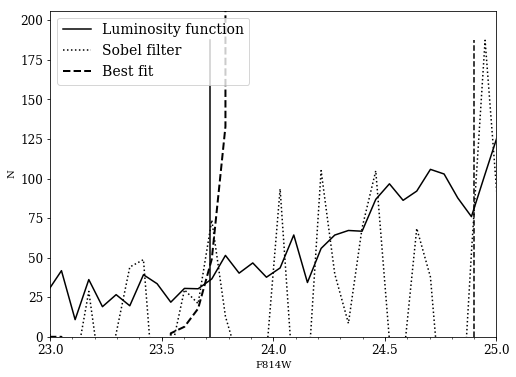

In [28]:
        #arr = CONFIG['parr']
        arr_roi=[]
        for x in zip(inputV,inputI):
            if (x[0]-x[1]>=PLT['cl'] and x[0]-x[1]<=PLT['ch'] and x[1]>=INIT['TRGB']+RANGE['l'] and x[1]<=INIT['TRGB']+RANGE['h']):
                arr_roi.append(x)
        arr_roi = np.asarray(arr_roi)

        fig=plt.figure()


        # Scaling fitting result for demonstration #
        for i in range(len(m)):
            if m[i] >= BFIT[3]:
                scale_r = (smoothLF[i]+smoothLF[i-1])/(bestrLF[i]+bestrLF[i-1])


                break

        pltfittics = []
        pltbestrLF = []
        for i in range(len(m)-1):
            if m[i] >= INIT['TRGB']+RANGE['l'] and m[i] <= INIT['TRGB']+RANGE['h']:
                pltfittics.append(m[i])
                pltbestrLF.append(bestrLF[i]*scale_r)
#                if bestrLF[i]*scale_r<0.001 : print magtics_smooth[i],bestrLF[i]
#        print scale_r


lf = plt.figure(figsize=(8,6))
ax = lf.add_subplot(1,1,1)
majorLocator = MultipleLocator(0.5)
minorLocator = MultipleLocator(0.1)
plt.rc('font',family='serif',size=18)
ax.set_xlabel(band2)
ax.set_ylabel("N")
smoothLF_for_plot = smoothLF * normalization
ax.plot(m,smoothLF_for_plot, 'k',color='black', label='Luminosity function')
plt.rc('xtick',labelsize='12')
plt.rc('ytick',labelsize='12')

ax.set_xlim((PLT['ml'],PLT['mh']))
ymax = np.amax(smoothLF_for_plot)
sobel_max = np.amax(LF_sobel)
LF_sobel_for_plot = LF_sobel/sobel_max * ymax
ax.plot(m,LF_sobel_for_plot,':',color='black', label='Sobel filter')
ax.set_ylim((0,ymax+(ymax/10))) 
pltbestrLF_for_plot = [x*normalization for x in pltbestrLF]
ax.plot(pltfittics, pltbestrLF_for_plot, 'k--',color='black', linewidth=2, label='Best fit')
ax.plot([ INIT['TRGB']+RANGE['l'], INIT['TRGB']+RANGE['l'] ], [0,ymax], '--', color='black')
ax.plot([ INIT['TRGB']+RANGE['h'], INIT['TRGB']+RANGE['h'] ], [0,ymax], '--', color='black')
ax.plot([BFIT[3],BFIT[3]],[0,ymax], '-', color='black')
ax.plot([BFIT[3]-perr[3],BFIT[3]-perr[3]],[0,ymax], '-.', color='black')
ax.plot([BFIT[3]+perr[3],BFIT[3]+perr[3]],[0,ymax], '-.', color='black')

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator) 
#ax.yaxis.set_major_locator(majorLocator)
#ax.yaxis.set_minor_locator(minorLocator) 
legend = ax.legend(loc='upper left',fontsize=14)
plt.savefig('lf.ps', dpi=300)



In [29]:
normalization

207.60335387154592